In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r "/content/drive/MyDrive/inaturalist_12K/train" "/content/train"

In [3]:
!cp -r "/content/drive/MyDrive/inaturalist_12K/test" "/content/test"

In [ ]:
import os
import random
from tensorflow.keras.preprocessing import image_dataset_from_directory

# --- 1. Define Paths and Parameters ---
dataset_path = '/content/train'  # Path to your train folder
split_ratio = 0.2  # Percentage for the validation set
seed = 42  # For reproducibility
image_size = (224, 224)  # Example image size
batch_size = 32

# --- 2. Get List of Categories (Subfolders in the train directory) ---
categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print(f"Found categories: {categories}")

# --- 3. Create Image Datasets using image_dataset_from_directory with a validation split ---
train_dataset = image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size,
    validation_split=split_ratio,
    subset='training',
    seed=seed,
    shuffle=True
)

val_dataset = image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size,
    validation_split=split_ratio,
    subset='validation',
    seed=seed,
    shuffle=False
)

print(f"Number of training batches: {len(train_dataset)}")
print(f"Number of validation batches: {len(val_dataset)}")
print(f"Class names: {train_dataset.class_names}")

# Now you have the train_dataset and val_dataset ready to be used for training.

Found categories: ['Reptilia', 'Mollusca', 'Arachnida', 'Mammalia', 'Amphibia', 'Plantae', 'Animalia', 'Insecta', 'Fungi', 'Aves']
Found 9999 files belonging to 10 classes.
Using 8000 files for training.
Found 9999 files belonging to 10 classes.
Using 1999 files for validation.
Number of training batches: 250
Number of validation batches: 63
Class names: ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


In [ ]:
import wandb
wandb.login()
# wandb.init(project="inaturalist_12K_training")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mm21b051 (mm21b051-iitmaana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from collections import defaultdict
import random
import wandb
from tqdm import tqdm
import numpy as np

# Define the CNN model (as in Question 1, with batch norm and dropout)
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10,
                 conv_filters=[16, 32, 64, 128, 256],
                 conv_kernel_size=3,
                 conv_activation=nn.ReLU(),
                 use_batchnorm=False,
                 dropout_rate=0.0,
                 dense_neurons=128,
                 dense_activation=nn.ReLU()):
        super(SimpleCNN, self).__init__()

        self.conv_layers = nn.ModuleList()
        if isinstance(conv_kernel_size, int):
            conv_kernel_size = [conv_kernel_size] * 5
        elif len(conv_kernel_size) != 5:
            raise ValueError("conv_kernel_size must be an integer or a list of 5 integers.")

        in_c = in_channels
        for i in range(5):
            out_c = conv_filters[i]
            kernel_size = conv_kernel_size[i]
            layers = [nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=kernel_size // 2)]
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(conv_activation)
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            if dropout_rate > 0 and i < 4: # Adding dropout after activation in conv layers (except the last)
                layers.append(nn.Dropout(dropout_rate))
            self.conv_layers.extend(layers)
            in_c = out_c

        self._to_linear = None
        self._determine_linear_input_size((1, in_channels, 64, 64)) # Example input size

        self.dense1 = nn.Linear(self._to_linear, dense_neurons)
        self.dense_activation = dense_activation
        if dropout_rate > 0:
            self.dropout_dense = nn.Dropout(dropout_rate) # Dropout before activation in dense layer
        else:
            self.dropout_dense = nn.Identity()
        self.fc = nn.Linear(dense_neurons, num_classes)

    def _determine_linear_input_size(self, input_shape):
        x = torch.randn(input_shape)
        self.eval()
        with torch.no_grad():
            for layer in self.conv_layers:
                x = layer(x)
            self._to_linear = x.view(x.size(0), -1).shape[1]
        self.train()

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout_dense(x)
        x = self.dense1(x)
        x = self.dense_activation(x)
        x = self.fc(x)
        return x

def load_and_split_inaturalist(root='./data', val_size_per_class=50, transform_train=None, transform_val=None, seed=42):
    full_train_dataset = datasets.INaturalist(root=root, version='2021_train', download=True, transform=transform_train)
    targets = full_train_dataset.targets
    class_indices = defaultdict(list)
    for i, target in enumerate(targets):
        class_indices[target].append(i)

    all_classes = sorted(class_indices.keys())
    train_indices = []
    val_indices = []

    random.seed(seed)
    for cls in all_classes:
        indices = class_indices[cls]
        random.shuffle(indices)
        val_indices.extend(indices[:val_size_per_class])
        train_indices.extend(indices[val_size_per_class:])

    train_subset = Subset(full_train_dataset, train_indices)
    val_subset = Subset(full_train_dataset, val_indices)

    if transform_val:
        val_subset.dataset.transform = transform_val

    return train_subset, val_subset

def train():
    with wandb.init():
        config = wandb.config

        # Define transformations
        transform_train_list = [transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
        transform_val_list = [transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]

        if config.data_augmentation:
            transform_train_list.insert(0, transforms.RandomHorizontalFlip())
            transform_train_list.insert(0, transforms.RandomResizedCrop(224, scale=(0.8, 1.0)))

        transform_train = transforms.Compose(transform_train_list)
        transform_val = transforms.Compose(transform_val_list)

        # Load and split the dataset
        train_dataset, val_dataset = load_and_split_inaturalist(val_size_per_class=50, transform_train=transform_train, transform_val=transform_val)
        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size * 2, shuffle=False, num_workers=4) # Increased batch size for validation

        # Instantiate the model
        conv_filter_config = []
        if config.filter_organisation == 'same':
            conv_filter_config = [config.num_filters] * 5
        elif config.filter_organisation == 'doubling':
            base_filters = config.num_filters
            conv_filter_config = [base_filters * (2**i) for i in range(5)]
        elif config.filter_organisation == 'halving':
            base_filters = config.num_filters * (2**4) # Start with a larger number
            conv_filter_config = [int(base_filters / (2**i)) for i in range(5)]
        elif config.filter_organisation == 'custom':
            conv_filter_config = [config.num_filters_layer1, config.num_filters_layer2, config.num_filters_layer3, config.num_filters_layer4, config.num_filters_layer5]
        else:
            raise ValueError(f"Invalid filter organisation: {config.filter_organisation}")

        activation_map = {'ReLU': nn.ReLU(), 'GELU': nn.GELU(), 'SiLU': nn.SiLU(), 'Mish': nn.Mish()}
        conv_act = activation_map.get(config.conv_activation, nn.ReLU())
        dense_act = activation_map.get(config.dense_activation, nn.ReLU())

        model = SimpleCNN(in_channels=3, num_classes=10,
                          conv_filters=conv_filter_config,
                          conv_kernel_size=3,
                          conv_activation=conv_act,
                          use_batchnorm=config.batch_norm,
                          dropout_rate=config.dropout,
                          dense_neurons=config.dense_neurons,
                          dense_activation=dense_act).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

        # Early stopping parameters
        patience = 5
        best_val_loss = np.inf
        epochs_without_improvement = 0

        # Training loop
        for epoch in range(config.epochs):
            model.train()
            train_loss = 0.0
            correct_train = 0
            total_train = 0
            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} (Train)"):
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_loss /= len(train_loader.dataset)
            train_accuracy = correct_train / total_train
            wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, 'epoch': epoch})

            # Validation loop
            model.eval()
            val_loss = 0.0
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} (Val)"):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            val_loss /= len(val_loader.dataset)
            val_accuracy = correct_val / total_val
            wandb.log({'val_loss': val_loss, 'val_accuracy': val_accuracy, 'epoch': epoch})

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Early stopping triggered after {epoch + 1} epochs.")
                    break

        return val_accuracy

if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define the sweep configuration for Bayesian Optimization
    sweep_config = {
        'method': 'bayes',
        'metric': {
            'name': 'val_accuracy',
            'goal': 'maximize'
        },
        'parameters': {
            'num_filters': {'values': [32, 64, 128]},
            'num_filters_layer1': {'values': [16, 32]},
            'num_filters_layer2': {'values': [32, 64]},
            'num_filters_layer3': {'values': [64, 128]},
            'num_filters_layer4': {'values': [128, 256]},
            'num_filters_layer5': {'values': [256, 512]},
            'filter_organisation': {'values': ['same', 'doubling', 'halving', 'custom']},
            'conv_activation': {'values': ['ReLU', 'GELU', 'SiLU', 'Mish']},
            'data_augmentation': {'values': [True, False]},
            'batch_norm': {'values': [True, False]},
            'dropout': {'values': [0.0, 0.2, 0.3]},
            'learning_rate': {'distribution': 'log_uniform', 'min': -5, 'max': -3}, # Log uniform for learning rate
            'epochs': {'value': 20}, # Increased max epochs
            'batch_size': {'values': [32, 64]},
            'dense_neurons': {'values': [64, 128, 256]},
            'dense_activation': {'values': ['ReLU', 'Tanh']},
            'weight_decay': {'distribution': 'log_uniform', 'min': -6, 'max': -2} # Add weight decay
        }
    }

    # Initialize the sweep
    sweep_id = wandb.sweep(sweep_config, project="inaturalist_cnn_bayesian")

    # Run the sweep agent
    wandb.agent(sweep_id, train, count=1) # Run for a number of trials

Using device: cuda


wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. learning_rate uses log_uniform, where min/max specify base-e exponents. Use log_uniform_values to specify limit values.
wandb: WARNING   Violation 2. weight_decay uses log_uniform, where min/max specify base-e exponents. Use log_uniform_values to specify limit values.


Create sweep with ID: 81fpttg2
Sweep URL: https://wandb.ai/mm21b051-iitmaana/inaturalist_cnn_bayesian/sweeps/81fpttg2


wandb: Agent Starting Run: h01mc6sp with config:
wandb: 	batch_norm: True
wandb: 	batch_size: 64
wandb: 	conv_activation: Mish
wandb: 	data_augmentation: False
wandb: 	dense_activation: Tanh
wandb: 	dense_neurons: 256
wandb: 	dropout: 0.3
wandb: 	epochs: 20
wandb: 	filter_organisation: halving
wandb: 	learning_rate: 0.019168022569397813
wandb: 	num_filters: 64
wandb: 	num_filters_layer1: 16
wandb: 	num_filters_layer2: 32
wandb: 	num_filters_layer3: 64
wandb: 	num_filters_layer4: 256
wandb: 	num_filters_layer5: 256
wandb: 	weight_decay: 0.0321930088429653


  1%|          | 2.34G/240G [00:42<1:12:54, 54.3MB/s]wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
run=wandb.init()
run.finish()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import wandb
from tqdm import tqdm
import numpy as np
import os

# Define the CNN model (as before)
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10,
                 conv_filters=[16, 32, 64, 128, 256],
                 conv_kernel_size=3,
                 conv_activation=nn.ReLU(),
                 use_batchnorm=False,
                 dropout_rate=0.0,
                 dense_neurons=128,
                 dense_activation=nn.ReLU()):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        if isinstance(conv_kernel_size, int):
            conv_kernel_size = [conv_kernel_size] * 5
        elif len(conv_kernel_size) != 5:
            raise ValueError("conv_kernel_size must be an integer or a list of 5 integers.")

        in_c = in_channels
        for i in range(5):
            out_c = conv_filters[i]
            kernel_size = conv_kernel_size[i]
            layers = [nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=kernel_size // 2)]
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(conv_activation)
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            if dropout_rate > 0 and i < 4:
                layers.append(nn.Dropout(dropout_rate))
            self.conv_layers.extend(layers)
            in_c = out_c

        self._to_linear = None
        self._determine_linear_input_size((1, in_channels, 224, 224))

        self.dense1 = nn.Linear(self._to_linear, dense_neurons)
        self.dense_activation = dense_activation
        if dropout_rate > 0:
            self.dropout_dense = nn.Dropout(dropout_rate)
        else:
            self.dropout_dense = nn.Identity()
        self.fc = nn.Linear(dense_neurons, num_classes)

    def _determine_linear_input_size(self, input_shape):
        x = torch.randn(input_shape)
        self.eval()
        with torch.no_grad():
            for layer in self.conv_layers:
                x = layer(x)
            self._to_linear = x.view(x.size(0), -1).shape[1]
        self.train()

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout_dense(x)
        x = self.dense1(x)
        x = self.dense_activation(x)
        x = self.fc(x)
        return x

def load_and_split_data(data_dir, val_split=0.2, batch_size=32, seed=42):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    num_samples = len(full_dataset)
    val_size = int(val_split * num_samples)
    train_size = num_samples - val_size

    generator = torch.Generator().manual_seed(seed)
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size * 2, shuffle=False, num_workers=4)

    return train_loader, val_loader, full_dataset.classes


# def train():
#     with wandb.init() as run:
#         config = wandb.config

#         # Load the data using the same parameters for all sweep runs
#         data_dir = '/content/drive/MyDrive/inaturalist_12K/train'
#         # train_loader, val_loader, class_names = load_and_split_data(
#         #     data_dir=data_dir,
#         #     val_split=0.2,
#         #     batch_size=config.batch_size, # Use batch size from sweep config
#         #     seed=42 # Keep the split consistent
#         # )
#         num_classes = len(class_names)

#         # Define transformations (including augmentation based on config)
#         transform_train_list = [
#             transforms.Resize((224, 224)),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#         ]
#         if config.data_augmentation:
#             transform_train_list.insert(0, transforms.RandomHorizontalFlip())
#             transform_train_list.insert(0, transforms.RandomResizedCrop(224, scale=(0.8, 1.0)))
#         train_loader.dataset.dataset.transform = transforms.Compose(transform_train_list)
#         val_loader.dataset.dataset.transform = transforms.Compose([
#             transforms.Resize((224, 224)),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#         ])

#         # Instantiate the model
#         conv_filter_config = []
#         if config.filter_organisation == 'same':
#             conv_filter_config = [config.num_filters] * 5
#         elif config.filter_organisation == 'doubling':
#             base_filters = config.num_filters
#             conv_filter_config = [base_filters * (2**i) for i in range(5)]
#         elif config.filter_organisation == 'halving':
#             base_filters = config.num_filters * (2**4)
#             conv_filter_config = [int(base_filters / (2**i)) for i in range(5)]
#         elif config.filter_organisation == 'custom':
#             conv_filter_config = [config.num_filters_layer1, config.num_filters_layer2, config.num_filters_layer3, config.num_filters_layer4, config.num_filters_layer5]
#         else:
#             raise ValueError(f"Invalid filter organisation: {config.filter_organisation}")

#         activation_map = {'ReLU': nn.ReLU(), 'GELU': nn.GELU(), 'SiLU': nn.SiLU(), 'Mish': nn.Mish()}
#         conv_act = activation_map.get(config.conv_activation, nn.ReLU())
#         dense_act = activation_map.get(config.dense_activation, nn.ReLU())

#         model = SimpleCNN(in_channels=3, num_classes=num_classes,
#                           conv_filters=conv_filter_config,
#                           conv_kernel_size=3,
#                           conv_activation=conv_act,
#                           use_batchnorm=config.batch_norm,
#                           dropout_rate=config.dropout,
#                           dense_neurons=config.dense_neurons,
#                           dense_activation=dense_act).to(device)

#         criterion = nn.CrossEntropyLoss()
#         optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

#         # Early stopping parameters
#         patience = 5
#         best_val_loss = np.inf
#         epochs_without_improvement = 0

#         # Training loop
#         for epoch in range(config.epochs):
#             model.train()
#             train_loss = 0.0
#             correct_train = 0
#             total_train = 0
#             for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} (Train)"):
#                 images, labels = images.to(device), labels.to(device)
#                 optimizer.zero_grad()
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()
#                 train_loss += loss.item() * images.size(0)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total_train += labels.size(0)
#                 correct_train += (predicted == labels).sum().item()

#             train_loss /= len(train_loader.dataset)
#             train_accuracy = correct_train / total_train
#             wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, 'epoch': epoch})

#             # Validation loop
#             model.eval()
#             val_loss = 0.0
#             correct_val = 0
#             total_val = 0
#             with torch.no_grad():
#                 for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} (Val)"):
#                     images, labels = images.to(device), labels.to(device)
#                     outputs = model(images)
#                     loss = criterion(outputs, labels)
#                     val_loss += loss.item() * images.size(0)
#                     _, predicted = torch.max(outputs.data, 1)
#                     total_val += labels.size(0)
#                     correct_val += (predicted == labels).sum().item()

#             val_loss /= len(val_loader.dataset)
#             val_accuracy = correct_val / total_val
#             wandb.log({'val_loss': val_loss, 'val_accuracy': val_accuracy, 'epoch': epoch})

#             # Early stopping check
#             if val_loss < best_val_loss:
#                 best_val_loss = val_loss
#                 epochs_without_improvement = 0
#             else:
#                 epochs_without_improvement += 1
#                 if epochs_without_improvement >= patience:
#                     print(f"Early stopping triggered after {epoch + 1} epochs.")
#                     break

#         return val_accuracy

# if __name__ == '__main__':
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"Using device: {device}")

#     sweep_config = {
#         'method': 'bayes',
#         'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
#         'parameters': {
#             'num_filters': {'values': [32, 64]},
#             'filter_organisation': {'values': ['same', 'doubling']},
#             'conv_activation': {'values': ['ReLU', 'GELU']},
#             'data_augmentation': {'values': [True, False]},
#             'batch_norm': {'values': [True, False]},
#             'dropout': {'values': [0.0, 0.2]},
#             'learning_rate': {'distribution': 'log_uniform_values', 'min': 1e-5, 'max': 1e-3},
#             'epochs': {'value': 5},
#             'batch_size': {'values': [32]},
#             'dense_neurons': {'values': [64]}
#         }
#     }

#     sweep_id = wandb.sweep(sweep_config, project="inaturalist_pytorch_sweep")
#     wandb.agent(sweep_id, train, count=5)

# if __name__ == '__main__':

#     data_dir = '/content/drive/MyDrive/inaturalist_12K/train'
#     train_loader, val_loader, class_names = load_and_split_data(
#                 data_dir=data_dir,
#                 val_split=0.2,
#                 batch_size=32, # Use batch size from sweep config
#                 seed=42 # Keep the split consistent
#             )


#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     print(f"Using device: {device}")

#     sweep_config = {
#         'method': 'bayes',
#         'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
#         'parameters': {
#             'num_filters': {'values': [32, 64]},
#             'filter_organisation': {'values': ['same', 'doubling']},
#             'conv_activation': {'values': ['ReLU', 'GELU']},
#             'data_augmentation': {'values': [True, False]},
#             'batch_norm': {'values': [True, False]},
#             'dropout': {'values': [0.0, 0.2]},
#             'learning_rate': {'distribution': 'log_uniform_values', 'min': 1e-5, 'max': 1e-3},
#             'epochs': {'value': 5},
#             'dense_neurons': {'values': [64]},
#             'dense_activation': {'values': ['ReLU', 'Tanh']},
#             'weight_decay': {'distribution': 'log_uniform_values', 'min': 1e-6, 'max': 1e-2} # Add this line
#         }
#     }

#     def train_wrapper():
#         return train(train_loader_main, val_loader_main, class_names_main)

#     sweep_id = wandb.sweep(sweep_config, project="inaturalist_pytorch_sweep")
#     wandb.agent(sweep_id, train, count=5)

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import wandb
import os

# --- Define global variables ---
data_dir_global = '/content/train'
val_split_global = 0.2
batch_size_global = 32
seed_global = 42
train_loader_global = None
val_loader_global = None
class_names_global = None

def load_and_split_data(data_dir, val_split, batch_size, seed):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    num_samples = len(full_dataset)
    val_size = int(val_split * num_samples)
    train_size = num_samples - val_size

    generator = torch.Generator().manual_seed(seed)
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())
    val_loader = DataLoader(val_dataset, batch_size=batch_size * 2, shuffle=False, num_workers=os.cpu_count())

    return train_loader, val_loader, full_dataset.classes

def train():
    global train_loader_global, val_loader_global, class_names_global
    with wandb.init() as run:
        config = wandb.config

        # Use the global variables
        train_loader = train_loader_global
        val_loader = val_loader_global
        class_names = class_names_global
        num_classes = len(class_names)

        # Apply augmentation based on config (to the global train_loader's dataset)
        transform_train_list = [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]
        if config.data_augmentation:
            transform_train_list.insert(0, transforms.RandomHorizontalFlip())
            transform_train_list.insert(0, transforms.RandomResizedCrop(224, scale=(0.8, 1.0)))
        train_loader.dataset.dataset.transform = transforms.Compose(transform_train_list)
        val_loader.dataset.dataset.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # if train_loader and train_loader.dataset:
        #     if hasattr(train_loader.dataset, 'dataset'): # For Subset
        #         train_loader.dataset.dataset.transform = transforms.Compose(transform_train_list)
        #     else:
        #         train_loader.dataset.transform = transforms.Compose(transform_train_list)

        # The validation transform should remain consistent
        val_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        if val_loader and val_loader.dataset:
            if hasattr(val_loader.dataset, 'dataset'): # For Subset
                val_loader.dataset.dataset.transform = val_transform
            else:
                val_loader.dataset.transform = val_transform

        # ... (rest of your training loop using train_loader and val_loader) ...
        # Instantiate the model
        conv_filter_config = []
        if config.filter_organisation == 'same':
            conv_filter_config = [config.num_filters] * 5
        elif config.filter_organisation == 'doubling':
            base_filters = config.num_filters
            conv_filter_config = [base_filters * (2**i) for i in range(5)]
        elif config.filter_organisation == 'halving':
            base_filters = config.num_filters * (2**4)
            conv_filter_config = [int(base_filters / (2**i)) for i in range(5)]
        elif config.filter_organisation == 'custom':
            conv_filter_config = [config.num_filters_layer1, config.num_filters_layer2, config.num_filters_layer3, config.num_filters_layer4, config.num_filters_layer5]
        else:
            raise ValueError(f"Invalid filter organisation: {config.filter_organisation}")

        activation_map = {'ReLU': nn.ReLU(), 'GELU': nn.GELU(), 'SiLU': nn.SiLU(), 'Mish': nn.Mish()}
        conv_act = activation_map.get(config.conv_activation, nn.ReLU())
        dense_act = activation_map.get(config.dense_activation, nn.ReLU())

        model = SimpleCNN(in_channels=3, num_classes=num_classes,
                          conv_filters=conv_filter_config,
                          conv_kernel_size=3,
                          conv_activation=conv_act,
                          use_batchnorm=config.batch_norm,
                          dropout_rate=config.dropout,
                          dense_neurons=config.dense_neurons,
                          dense_activation=dense_act).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

        # Early stopping parameters
        patience = 5
        best_val_loss = np.inf
        epochs_without_improvement = 0

        # Training loop
        for epoch in range(config.epochs):
            model.train()
            train_loss = 0.0
            correct_train = 0
            total_train = 0
            for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} (Train)"):
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_loss /= len(train_loader.dataset)
            train_accuracy = correct_train / total_train
            wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, 'epoch': epoch})

            # Validation loop
            model.eval()
            val_loss = 0.0
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} (Val)"):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            val_loss /= len(val_loader.dataset)
            val_accuracy = correct_val / total_val
            wandb.log({'val_loss': val_loss, 'val_accuracy': val_accuracy, 'epoch': epoch})

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print(f"Early stopping triggered after {epoch + 1} epochs.")
                    break

        return val_accuracy


if __name__ == '__main__':
    import os
    num_cpu = os.cpu_count()

    train_loader_global, val_loader_global, class_names_global = load_and_split_data(
        data_dir=data_dir_global,
        val_split=val_split_global,
        batch_size=batch_size_global,
        seed=seed_global
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    sweep_config = {
        'method': 'bayes',
        'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
        'parameters': {
            'num_filters': {'values': [32, 64]},
            'filter_organisation': {'values': ['same', 'doubling']},
            'conv_activation': {'values': ['ReLU', 'GELU']},
            'data_augmentation': {'values': [True, False]},
            'batch_norm': {'values': [True, False]},
            'dropout': {'values': [0.0, 0.2]},
            'learning_rate': {'distribution': 'log_uniform_values', 'min': 1e-5, 'max': 1e-3},
            'epochs': {'value': 5},
            'dense_neurons': {'values': [64]},
            'dense_activation': {'values': ['ReLU', 'Tanh']},
            'weight_decay': {'distribution': 'log_uniform_values', 'min': 1e-6, 'max': 1e-2} # Add this line
        }
    }
    sweep_config = {
        'method': 'bayes',
        'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
        'parameters': {
            'num_filters': {'values': [32, 64]},
            'filter_organisation': {'values': ['same', 'doubling']},
            'conv_activation': {'values': ['GELU']},
            'data_augmentation': {'values': [True]},
            'batch_norm': {'values': [True]},
            'dropout': {'values': [0.0, 0.2]},
            'learning_rate': {'distribution': 'log_uniform_values', 'min': 1e-5, 'max': 1e-4},
            'epochs': {'value': 10},
            'dense_neurons': {'values': [64]},
            'dense_activation': {'values': ['ReLU', 'Tanh']},
            'weight_decay': {'distribution': 'log_uniform_values', 'min': 1e-3, 'max': 1e-2} # Add this line
        }
    }

    sweep_id = wandb.sweep(sweep_config, project="inaturalist_pytorch_sweep2")
    wandb.agent(sweep_id, train, count=20)

Using device: cuda


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: dsg52v6u
Sweep URL: https://wandb.ai/mm21b051-iitmaana/inaturalist_pytorch_sweep2/sweeps/dsg52v6u


wandb: Agent Starting Run: hgx4t746 with config:
wandb: 	batch_norm: True
wandb: 	conv_activation: GELU
wandb: 	data_augmentation: True
wandb: 	dense_activation: Tanh
wandb: 	dense_neurons: 64
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	filter_organisation: doubling
wandb: 	learning_rate: 5.443253923803749e-05
wandb: 	num_filters: 64
wandb: 	weight_decay: 0.0033653248896940275
wandb: Currently logged in as: mm21b051 (mm21b051-iitmaana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 9 (Val): 100%|██████████| 32/32 [00:19<00:00,  1.61it/s]

Early stopping triggered after 9 epochs.


wandb: Agent Starting Run: 9mtf4c4p with config:
wandb: 	batch_norm: True
wandb: 	conv_activation: GELU
wandb: 	data_augmentation: True
wandb: 	dense_activation: Tanh
wandb: 	dense_neurons: 64
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	filter_organisation: same
wandb: 	learning_rate: 6.776897478285904e-05
wandb: 	num_filters: 32
wandb: 	weight_decay: 0.0022174751202936912


Epoch 10 (Val): 100%|██████████| 32/32 [00:20<00:00,  1.53it/s]


wandb: Agent Starting Run: rkmbl98y with config:
wandb: 	batch_norm: True
wandb: 	conv_activation: GELU
wandb: 	data_augmentation: True
wandb: 	dense_activation: ReLU
wandb: 	dense_neurons: 64
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	filter_organisation: doubling
wandb: 	learning_rate: 4.134570887500984e-05
wandb: 	num_filters: 32
wandb: 	weight_decay: 0.0012069217958426675


Epoch 10 (Val): 100%|██████████| 32/32 [00:20<00:00,  1.57it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xza6ncyq with config:
wandb: 	batch_norm: True
wandb: 	conv_activation: GELU
wandb: 	data_augmentation: True
wandb: 	dense_activation: ReLU
wandb: 	dense_neurons: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filter_organisation: same
wandb: 	learning_rate: 3.566672377931987e-05
wandb: 	num_filters: 64
wandb: 	weight_decay: 0.0030346365015601856


Epoch 7 (Val): 100%|██████████| 32/32 [00:19<00:00,  1.64it/s]

Early stopping triggered after 7 epochs.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ym39u9sd with config:
wandb: 	batch_norm: True
wandb: 	conv_activation: GELU
wandb: 	data_augmentation: True
wandb: 	dense_activation: Tanh
wandb: 	dense_neurons: 64
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	filter_organisation: same
wandb: 	learning_rate: 6.566385983690451e-05
wandb: 	num_filters: 32
wandb: 	weight_decay: 0.0013230752921082486


Epoch 10 (Val): 100%|██████████| 32/32 [00:18<00:00,  1.70it/s]


wandb: Agent Starting Run: tfm1n8dy with config:
wandb: 	batch_norm: True
wandb: 	conv_activation: GELU
wandb: 	data_augmentation: True
wandb: 	dense_activation: Tanh
wandb: 	dense_neurons: 64
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	filter_organisation: doubling
wandb: 	learning_rate: 6.326527234349647e-05
wandb: 	num_filters: 64
wandb: 	weight_decay: 0.0012958057260856425


Epoch 10 (Val): 100%|██████████| 32/32 [00:21<00:00,  1.48it/s]


wandb: Agent Starting Run: jjwtjna7 with config:
wandb: 	batch_norm: True
wandb: 	conv_activation: GELU
wandb: 	data_augmentation: True
wandb: 	dense_activation: Tanh
wandb: 	dense_neurons: 64
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	filter_organisation: doubling
wandb: 	learning_rate: 3.760103804896991e-05
wandb: 	num_filters: 64
wandb: 	weight_decay: 0.0013808383741069066


Epoch 10 (Val): 100%|██████████| 32/32 [00:21<00:00,  1.49it/s]


wandb: Agent Starting Run: hrox1tye with config:
wandb: 	batch_norm: True
wandb: 	conv_activation: GELU
wandb: 	data_augmentation: True
wandb: 	dense_activation: Tanh
wandb: 	dense_neurons: 64
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	filter_organisation: doubling
wandb: 	learning_rate: 5.434902489614524e-05
wandb: 	num_filters: 32
wandb: 	weight_decay: 0.003128292990768865


Epoch 10 (Val): 100%|██████████| 32/32 [00:20<00:00,  1.55it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0xvuv5ia with config:
wandb: 	batch_norm: True
wandb: 	conv_activation: GELU
wandb: 	data_augmentation: True
wandb: 	dense_activation: Tanh
wandb: 	dense_neurons: 64
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	filter_organisation: doubling
wandb: 	learning_rate: 3.857088812730131e-05
wandb: 	num_filters: 32
wandb: 	weight_decay: 0.003193503030758834


Epoch 10 (Val): 100%|██████████| 32/32 [00:20<00:00,  1.54it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ehnpqgss with config:
wandb: 	batch_norm: True
wandb: 	conv_activation: GELU
wandb: 	data_augmentation: True
wandb: 	dense_activation: Tanh
wandb: 	dense_neurons: 64
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	filter_organisation: doubling
wandb: 	learning_rate: 9.92664708786805e-05
wandb: 	num_filters: 32
wandb: 	weight_decay: 0.004954710468394902


Epoch 10 (Val): 100%|██████████| 32/32 [00:23<00:00,  1.39it/s]


wandb: Agent Starting Run: akadqix5 with config:
wandb: 	batch_norm: True
wandb: 	conv_activation: GELU
wandb: 	data_augmentation: True
wandb: 	dense_activation: Tanh
wandb: 	dense_neurons: 64
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	filter_organisation: doubling
wandb: 	learning_rate: 9.306719659621348e-05
wandb: 	num_filters: 32
wandb: 	weight_decay: 0.002066255480083457


Epoch 9 (Val): 100%|██████████| 32/32 [00:19<00:00,  1.65it/s]

Early stopping triggered after 9 epochs.


wandb: Agent Starting Run: 8zh2ugr3 with config:
wandb: 	batch_norm: True
wandb: 	conv_activation: GELU
wandb: 	data_augmentation: True
wandb: 	dense_activation: ReLU
wandb: 	dense_neurons: 64
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	filter_organisation: doubling
wandb: 	learning_rate: 9.495639761731512e-05
wandb: 	num_filters: 32
wandb: 	weight_decay: 0.001025650601201426


Epoch 5 (Val):  12%|█▎        | 4/32 [00:03<00:21,  1.33it/s]

In [ ]:
    sweep_id = wandb.sweep(sweep_config, project="inaturalist_pytorch_sweep")
    wandb.agent(sweep_id, train, count=10)

Create sweep with ID: 2cxaxfz7
Sweep URL: https://wandb.ai/mm21b051-iitmaana/inaturalist_pytorch_sweep/sweeps/2cxaxfz7


wandb: Agent Starting Run: 6xl5lhro with config:
wandb: 	batch_norm: True
wandb: 	conv_activation: GELU
wandb: 	data_augmentation: True
wandb: 	dense_activation: Tanh
wandb: 	dense_neurons: 64
wandb: 	dropout: 0
wandb: 	epochs: 5
wandb: 	filter_organisation: doubling
wandb: 	learning_rate: 3.7615657615326334e-05
wandb: 	num_filters: 64
wandb: 	weight_decay: 0.00610135721432891


Epoch 5 (Val): 100%|██████████| 32/32 [00:21<00:00,  1.48it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xmxf0hm3 with config:
wandb: 	batch_norm: False
wandb: 	conv_activation: GELU
wandb: 	data_augmentation: False
wandb: 	dense_activation: Tanh
wandb: 	dense_neurons: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	filter_organisation: same
wandb: 	learning_rate: 0.0007079277710670556
wandb: 	num_filters: 32
wandb: 	weight_decay: 4.687094236186385e-06


Epoch 5 (Val): 100%|██████████| 32/32 [00:20<00:00,  1.56it/s]


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e8us96d1 with config:
wandb: 	batch_norm: True
wandb: 	conv_activation: ReLU
wandb: 	data_augmentation: True
wandb: 	dense_activation: ReLU
wandb: 	dense_neurons: 64
wandb: 	dropout: 0
wandb: 	epochs: 5
wandb: 	filter_organisation: same
wandb: 	learning_rate: 1.3407796235785585e-05
wandb: 	num_filters: 64
wandb: 	weight_decay: 2.258490625802787e-05


Epoch 5 (Val): 100%|██████████| 32/32 [00:19<00:00,  1.64it/s]


wandb: Agent Starting Run: qotgiiv0 with config:
wandb: 	batch_norm: False
wandb: 	conv_activation: ReLU
wandb: 	data_augmentation: False
wandb: 	dense_activation: Tanh
wandb: 	dense_neurons: 64
wandb: 	dropout: 0
wandb: 	epochs: 5
wandb: 	filter_organisation: doubling
wandb: 	learning_rate: 0.00017811922406995665
wandb: 	num_filters: 64
wandb: 	weight_decay: 1.1436560402406096e-06


Epoch 5 (Val): 100%|██████████| 32/32 [00:21<00:00,  1.48it/s]


wandb: Agent Starting Run: o06x2ulp with config:
wandb: 	batch_norm: False
wandb: 	conv_activation: GELU
wandb: 	data_augmentation: True
wandb: 	dense_activation: Tanh
wandb: 	dense_neurons: 64
wandb: 	dropout: 0
wandb: 	epochs: 5
wandb: 	filter_organisation: doubling
wandb: 	learning_rate: 1.115036305577273e-05
wandb: 	num_filters: 64
wandb: 	weight_decay: 0.0034897027111191296


Epoch 5 (Val): 100%|██████████| 32/32 [00:19<00:00,  1.62it/s]


wandb: Agent Starting Run: m8scg2ly with config:
wandb: 	batch_norm: True
wandb: 	conv_activation: GELU
wandb: 	data_augmentation: True
wandb: 	dense_activation: ReLU
wandb: 	dense_neurons: 64
wandb: 	dropout: 0
wandb: 	epochs: 5
wandb: 	filter_organisation: doubling
wandb: 	learning_rate: 9.220641763947516e-05
wandb: 	num_filters: 32
wandb: 	weight_decay: 0.003989026716465024


Epoch 5 (Val): 100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


wandb: Agent Starting Run: 9r99snb0 with config:
wandb: 	batch_norm: False
wandb: 	conv_activation: GELU
wandb: 	data_augmentation: True
wandb: 	dense_activation: ReLU
wandb: 	dense_neurons: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	filter_organisation: same
wandb: 	learning_rate: 5.611850914683482e-05
wandb: 	num_filters: 64
wandb: 	weight_decay: 4.832511636097763e-05


Epoch 5 (Val): 100%|██████████| 32/32 [00:19<00:00,  1.67it/s]


wandb: Agent Starting Run: y2vmr5xm with config:
wandb: 	batch_norm: True
wandb: 	conv_activation: GELU
wandb: 	data_augmentation: False
wandb: 	dense_activation: ReLU
wandb: 	dense_neurons: 64
wandb: 	dropout: 0
wandb: 	epochs: 5
wandb: 	filter_organisation: doubling
wandb: 	learning_rate: 0.0009010700506795864
wandb: 	num_filters: 64
wandb: 	weight_decay: 2.8504988581333697e-05


Epoch 5 (Val): 100%|██████████| 32/32 [00:20<00:00,  1.56it/s]


wandb: Agent Starting Run: sk44e5hj with config:
wandb: 	batch_norm: False
wandb: 	conv_activation: ReLU
wandb: 	data_augmentation: False
wandb: 	dense_activation: ReLU
wandb: 	dense_neurons: 64
wandb: 	dropout: 0
wandb: 	epochs: 5
wandb: 	filter_organisation: doubling
wandb: 	learning_rate: 0.000515961157300602
wandb: 	num_filters: 64
wandb: 	weight_decay: 2.0043697389094824e-05


Epoch 5 (Val): 100%|██████████| 32/32 [00:21<00:00,  1.47it/s]


wandb: Agent Starting Run: e65he6iw with config:
wandb: 	batch_norm: True
wandb: 	conv_activation: GELU
wandb: 	data_augmentation: True
wandb: 	dense_activation: Tanh
wandb: 	dense_neurons: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	filter_organisation: doubling
wandb: 	learning_rate: 0.0003223613965154382
wandb: 	num_filters: 64
wandb: 	weight_decay: 4.81240052017268e-06


Epoch 5 (Val): 100%|██████████| 32/32 [00:20<00:00,  1.59it/s]


In [ ]:
sweep_config = {
        'parameters': {
            'num_filters': {'values': [32]},
            'filter_organisation': {'values': ['doubling']},
            'conv_activation': {'values': ['GELU']},
            'data_augmentation': {'values': [True]},
            'batch_norm': {'values': [True]},
            'dropout': {'values': [0.0]},
            'learning_rate': {'distribution': 0.0001},
            'epochs': {'value': 10},
            'dense_neurons': {'values': [64]},
            'dense_activation': {'values': ['Tanh']},
            'weight_decay': {'distribution': 0.002} # Add this line
        }
    }

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mm21b051 (mm21b051-iitmaana) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda
Number of classes: 10
Training on the full training set...


Training: 100%|██████████| 282/282 [01:49<00:00,  2.57it/s]

Final Training Loss: 2.0784, Final Training Accuracy: 0.2496
Evaluating on the test set...


Test Loss: 1.9431 Test Accuracy: 0.3243


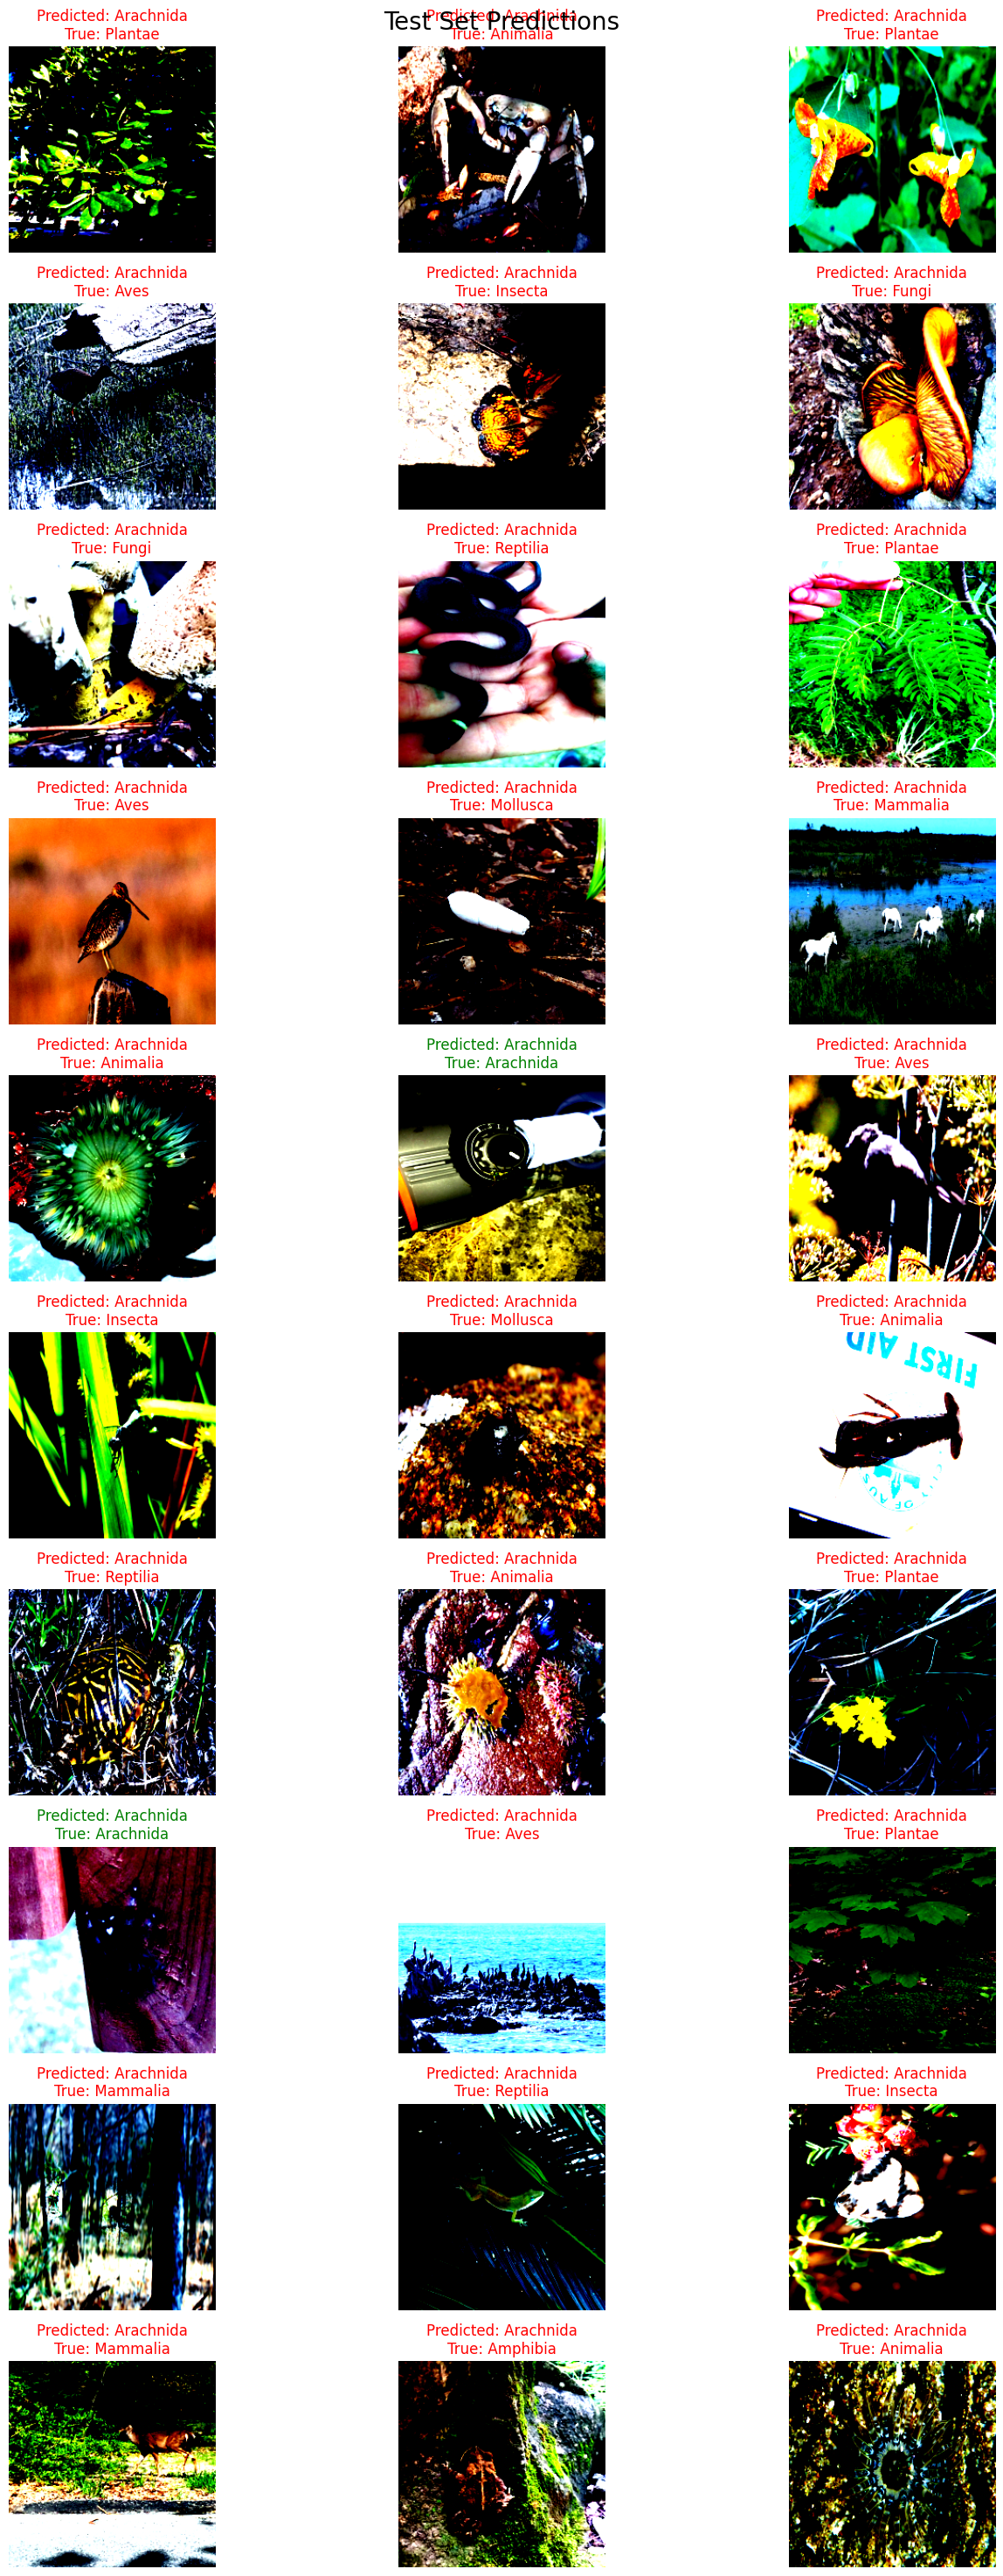

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import wandb
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Define the CNN model (same as before)
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10,
                 conv_filters=[16, 32, 64, 128, 256],
                 conv_kernel_size=3,
                 conv_activation=nn.ReLU(),
                 use_batchnorm=False,
                 dropout_rate=0.0,
                 dense_neurons=128,
                 dense_activation=nn.ReLU()):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        if isinstance(conv_kernel_size, int):
            conv_kernel_size = [conv_kernel_size] * 5
        elif len(conv_kernel_size) != 5:
            raise ValueError("conv_kernel_size must be an integer or a list of 5 integers.")

        in_c = in_channels
        for i in range(5):
            out_c = conv_filters[i]
            kernel_size = conv_kernel_size[i]
            layers = [nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=kernel_size // 2)]
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(conv_activation)
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            if dropout_rate > 0 and i < 4:
                layers.append(nn.Dropout(dropout_rate))
            self.conv_layers.extend(layers)
            in_c = out_c

        self._to_linear = None
        self._determine_linear_input_size((1, in_channels, 224, 224))

        self.dense1 = nn.Linear(self._to_linear, dense_neurons)
        self.dense_activation = dense_activation
        if dropout_rate > 0:
            self.dropout_dense = nn.Dropout(dropout_rate)
        else:
            self.dropout_dense = nn.Identity()
        self.fc = nn.Linear(dense_neurons, num_classes)

    def _determine_linear_input_size(self, input_shape):
        x = torch.randn(input_shape)
        self.eval()
        with torch.no_grad():
            for layer in self.conv_layers:
                x = layer(x)
            self._to_linear = x.view(x.size(0), -1).shape[1]
        self.train()

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout_dense(x)
        x = self.dense1(x)
        x = self.dense_activation(x)
        x = self.fc(x)
        return x

def load_data(data_dir, batch_size=32, test_split=0.1, seed=42):
    """
    Loads and preprocesses the iNaturalist 12K dataset, splitting it into training and testing sets.

    Args:
        data_dir (str): Path to the directory containing the dataset.
        batch_size (int): Batch size for the DataLoaders.
        test_split (float): The proportion of the data to use for the test set.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: (train_loader, test_loader, class_names)
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    num_samples = len(full_dataset)
    test_size = int(test_split * num_samples)
    train_size = num_samples - test_size

    generator = torch.Generator().manual_seed(seed)
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=generator)

    num_cpu = os.cpu_count()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_cpu)
    test_loader = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False, num_workers=num_cpu)

    return train_loader, test_loader, full_dataset.classes

def evaluate(model, loader, device, criterion, dataset_name="Validation"):
    """
    Evaluates the model on the given dataloader.

    Args:
        model (nn.Module): The PyTorch model to evaluate.
        loader (DataLoader): The DataLoader for the dataset.
        device (torch.device): The device to use (CPU or GPU).
        criterion (nn.Module): The loss function.
        dataset_name (str): Name of the dataset being evaluated

    Returns:
        tuple: (loss, accuracy)
    """
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    print(f'{dataset_name} Loss: {epoch_loss:.4f} {dataset_name} Accuracy: {epoch_accuracy:.4f}')
    return epoch_loss, epoch_accuracy

def train_and_test(best_config, train_dir, test_dir):
    """
    Loads the training and testing data, trains the model with the best hyperparameters,
    and evaluates it on the test set.  Logs results to Wandb.

    Args:
        best_config (dict): The dictionary containing the best hyperparameters found by Wandb Sweep.
        train_dir (str): Path to the directory containing the training dataset.
        test_dir (str): Path to the directory containing the testing dataset.
    """
    wandb.init(project="inaturalist_pytorch_train_and_test", job_type="final_run") #  "final_run"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load the data
    train_loader, test_loader, class_names = load_data(train_dir, batch_size=best_config['batch_size'])
    num_classes = len(class_names)
    print(f"Number of classes: {num_classes}")


    # Instantiate the model with the best hyperparameters
    conv_filter_config = []
    if best_config['filter_organisation'] == 'same':
        conv_filter_config = [best_config['num_filters']] * 5
    elif best_config['filter_organisation'] == 'doubling':
        base_filters = best_config['num_filters']
        conv_filter_config = [base_filters * (2**i) for i in range(5)]
    elif best_config['filter_organisation'] == 'halving':
        base_filters = best_config['num_filters'] * (2**4)
        conv_filter_config = [int(base_filters / (2**i)) for i in range(5)]
    elif best_config['filter_organisation'] == 'custom':
        conv_filter_config = [best_config['num_filters_layer1'], best_config['num_filters_layer2'],
                             best_config['num_filters_layer3'], best_config['num_filters_layer4'],
                             best_config['num_filters_layer5']]
    else:
        raise ValueError(f"Invalid filter organisation: {best_config['filter_organisation']}")

    activation_map = {'ReLU': nn.ReLU(), 'GELU': nn.GELU(), 'SiLU': nn.SiLU(), 'Mish': nn.Mish()}
    conv_act = activation_map.get(best_config['conv_activation'], nn.ReLU())
    dense_act = activation_map.get(best_config['dense_activation'], nn.ReLU())

    model = SimpleCNN(in_channels=3, num_classes=num_classes,
                      conv_filters=conv_filter_config,
                      conv_kernel_size=3,
                      conv_activation=conv_act,
                      use_batchnorm=best_config['batch_norm'],
                      dropout_rate=best_config['dropout'],
                      dense_neurons=best_config['dense_neurons'],
                      dense_activation=dense_act).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_config['learning_rate'], weight_decay=best_config['weight_decay'])

    # Train on the full training set
    print("Training on the full training set...")
    model.train()
    total_train_loss, correct_train, total_train = 0, 0, 0
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_loss = total_train_loss / total_train
    train_accuracy = correct_train / total_train
    print(f"Final Training Loss: {train_loss:.4f}, Final Training Accuracy: {train_accuracy:.4f}")
    wandb.log({'final_train_loss': train_loss, 'final_train_accuracy': train_accuracy})

    # Evaluate on the test set
    print("Evaluating on the test set...")
    test_loss, test_accuracy = evaluate(model, test_loader, device, criterion, dataset_name="Test")
    wandb.log({'test_loss': test_loss, 'test_accuracy': test_accuracy})

    wandb.finish()

def visualize_predictions(model, test_loader, class_names, device, num_images=30):
    """
    Visualizes a grid of images from the test set with their predicted and true labels.

    Args:
        model (nn.Module): The trained PyTorch model.
        test_loader (DataLoader): The DataLoader for the test set.
        class_names (list): A list of class names.
        device (torch.device): The device to use (CPU or GPU).
        num_images (int): The number of images to visualize.  Must be a multiple of 3.
    """
    model.eval()
    images, labels = next(iter(test_loader)) # Get a batch of images
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    fig = plt.figure(figsize=(15, 30))  # Adjust figure size as needed.
    fig.suptitle("Test Set Predictions", fontsize=20)
    for i in range(num_images):
        plt.subplot(10, 3, i + 1)  # Grid of 10 rows, 3 columns
        plt.imshow(images[i].cpu().permute(1, 2, 0).numpy())  # Convert to HWC and to numpy
        plt.axis('off')
        plt.title(f"Predicted: {class_names[predicted[i]]}\nTrue: {class_names[labels[i]]}",
                  color=("green" if predicted[i] == labels[i] else "red")) # Color-code correct/incorrect
    plt.tight_layout() # Adjust layout so titles don't overlap
    plt.show()

if __name__ == '__main__':
    #  dictionary containing the best hyperparameters found by Wandb Sweep.
    best_config = {
        'num_filters': 32,
        'filter_organisation': 'doubling',
        'conv_activation': 'GELU',
        'data_augmentation': True,
        'batch_norm': True,
        'dropout': 0.0,
        'learning_rate': 0.0001,
        'epochs': 10,
        'batch_size': 32,
        'dense_neurons': 64,
        'dense_activation': 'Tanh',
        'weight_decay': 0.002
    }

    train_dir = '/content/train'  #  train dataset path
    test_dir = '/content/test'
    # Load the test data
    _, test_loader, class_names = load_data(test_dir, batch_size=best_config['batch_size'])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instantiate the model with the best hyperparameters
    conv_filter_config = []
    if best_config['filter_organisation'] == 'doubling':
        base_filters = best_config['num_filters']
        conv_filter_config = [base_filters * (2**i) for i in range(5)]
    else:
        raise ValueError(f"Invalid filter organisation: {best_config['filter_organisation']}")

    activation_map = {'ReLU': nn.ReLU(), 'GELU': nn.GELU(), 'SiLU': nn.SiLU(), 'Mish': nn.Mish()}
    conv_act = activation_map.get(best_config['conv_activation'], nn.ReLU())
    dense_act = activation_map.get(best_config['dense_activation'], nn.ReLU())

    model = SimpleCNN(in_channels=3, num_classes=10,
                      conv_filters=conv_filter_config,
                      conv_kernel_size=3,
                      conv_activation=conv_act,
                      use_batchnorm=best_config['batch_norm'],
                      dropout_rate=best_config['dropout'],
                      dense_neurons=best_config['dense_neurons'],
                      dense_activation=dense_act).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_config['learning_rate'], weight_decay=best_config['weight_decay'])
    # Train the model
    train_and_test(best_config, train_dir, test_dir)

    # Visualize predictions on the test set
    visualize_predictions(model, test_loader, class_names, device)


Using device: cuda
Number of classes: 10
Training on the full training set...
Epoch 1/10


Training: 100%|██████████| 282/282 [01:43<00:00,  2.72it/s]


Epoch 1 Training Loss: 2.0518, Training Accuracy: 0.2687
Epoch 2/10


Training: 100%|██████████| 282/282 [01:36<00:00,  2.93it/s]


Epoch 2 Training Loss: 1.9554, Training Accuracy: 0.3051
Epoch 3/10


Training: 100%|██████████| 282/282 [01:36<00:00,  2.92it/s]


Epoch 3 Training Loss: 1.8782, Training Accuracy: 0.3359
Epoch 4/10


Training: 100%|██████████| 282/282 [01:35<00:00,  2.95it/s]


Epoch 4 Training Loss: 1.8074, Training Accuracy: 0.3639
Epoch 5/10


Training: 100%|██████████| 282/282 [01:34<00:00,  2.99it/s]


Epoch 5 Training Loss: 1.7368, Training Accuracy: 0.3906
Epoch 6/10


Training: 100%|██████████| 282/282 [01:36<00:00,  2.92it/s]


Epoch 6 Training Loss: 1.6669, Training Accuracy: 0.4171
Epoch 7/10


Training: 100%|██████████| 282/282 [01:34<00:00,  3.00it/s]


Epoch 7 Training Loss: 1.5959, Training Accuracy: 0.4445
Epoch 8/10


Training: 100%|██████████| 282/282 [01:37<00:00,  2.88it/s]


Epoch 8 Training Loss: 1.5216, Training Accuracy: 0.4744
Epoch 9/10


Training: 100%|██████████| 282/282 [01:34<00:00,  2.99it/s]


Epoch 9 Training Loss: 1.4427, Training Accuracy: 0.5062
Epoch 10/10


Training: 100%|██████████| 282/282 [01:37<00:00,  2.88it/s]

Epoch 10 Training Loss: 1.3597, Training Accuracy: 0.5400
Finished Training.  Final Training Loss: 1.3597, Final Training Accuracy: 0.5400
Evaluating on the test set...


Test Loss: 1.8402 Test Accuracy: 0.4044


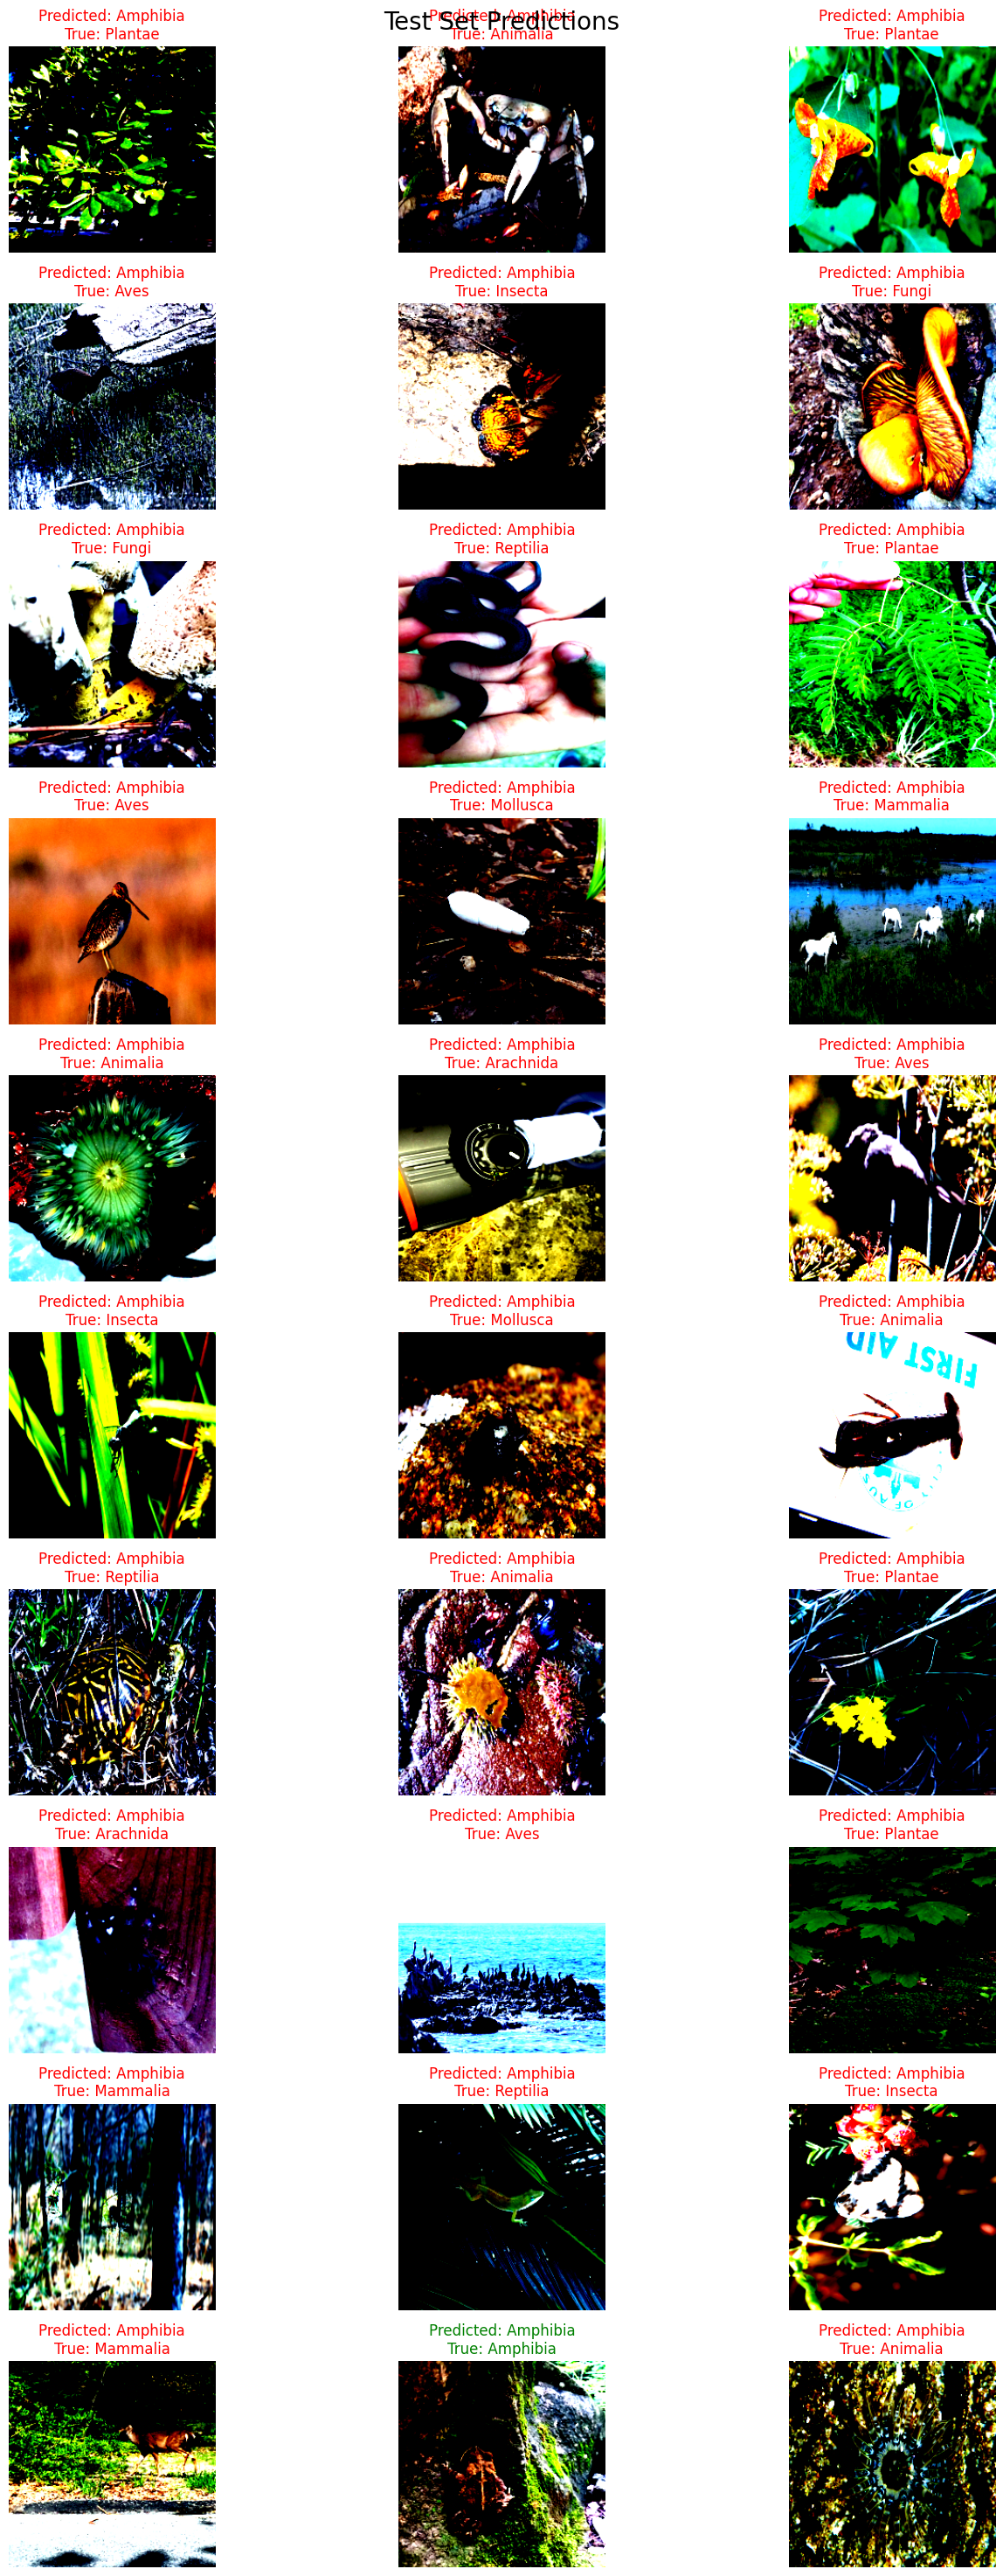

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import wandb
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Define the CNN model (same as before)
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10,
                 conv_filters=[16, 32, 64, 128, 256],
                 conv_kernel_size=3,
                 conv_activation=nn.ReLU(),
                 use_batchnorm=False,
                 dropout_rate=0.0,
                 dense_neurons=128,
                 dense_activation=nn.ReLU()):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.ModuleList()
        if isinstance(conv_kernel_size, int):
            conv_kernel_size = [conv_kernel_size] * 5
        elif len(conv_kernel_size) != 5:
            raise ValueError("conv_kernel_size must be an integer or a list of 5 integers.")

        in_c = in_channels
        for i in range(5):
            out_c = conv_filters[i]
            kernel_size = conv_kernel_size[i]
            layers = [nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=kernel_size // 2)]
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(conv_activation)
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            if dropout_rate > 0 and i < 4:
                layers.append(nn.Dropout(dropout_rate))
            self.conv_layers.extend(layers)
            in_c = out_c

        self._to_linear = None
        self._determine_linear_input_size((1, in_channels, 224, 224))

        self.dense1 = nn.Linear(self._to_linear, dense_neurons)
        self.dense_activation = dense_activation
        if dropout_rate > 0:
            self.dropout_dense = nn.Dropout(dropout_rate)
        else:
            self.dropout_dense = nn.Identity()
        self.fc = nn.Linear(dense_neurons, num_classes)

    def _determine_linear_input_size(self, input_shape):
        x = torch.randn(input_shape)
        self.eval()
        with torch.no_grad():
            for layer in self.conv_layers:
                x = layer(x)
            self._to_linear = x.view(x.size(0), -1).shape[1]
        self.train()

    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout_dense(x)
        x = self.dense1(x)
        x = self.dense_activation(x)
        x = self.fc(x)
        return x

def load_data(data_dir, batch_size=32, test_split=0.1, seed=42):
    """
    Loads and preprocesses the iNaturalist 12K dataset, splitting it into training and testing sets.

    Args:
        data_dir (str): Path to the directory containing the dataset.
        batch_size (int): Batch size for the DataLoaders.
        test_split (float): The proportion of the data to use for the test set.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: (train_loader, test_loader, class_names)
    """
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    num_samples = len(full_dataset)
    test_size = int(test_split * num_samples)
    train_size = num_samples - test_size

    generator = torch.Generator().manual_seed(seed)
    train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size], generator=generator)

    num_cpu = os.cpu_count()
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_cpu)
    test_loader = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False, num_workers=num_cpu)

    return train_loader, test_loader, full_dataset.classes

def evaluate(model, loader, device, criterion, dataset_name="Validation"):
    """
    Evaluates the model on the given dataloader.

    Args:
        model (nn.Module): The PyTorch model to evaluate.
        loader (DataLoader): The DataLoader for the dataset.
        device (torch.device): The device to use (CPU or GPU).
        criterion (nn.Module): The loss function.
        dataset_name (str): Name of the dataset being evaluated

    Returns:
        tuple: (loss, accuracy)
    """
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_accuracy = correct / total
    print(f'{dataset_name} Loss: {epoch_loss:.4f} {dataset_name} Accuracy: {epoch_accuracy:.4f}')
    return epoch_loss, epoch_accuracy

def train_and_test(best_config, train_dir, test_dir):
    """
    Loads the training and testing data, trains the model with the best hyperparameters,
    and evaluates it on the test set.  Logs results to Wandb.

    Args:
        best_config (dict): The dictionary containing the best hyperparameters found by Wandb Sweep.
        train_dir (str): Path to the directory containing the training dataset.
        test_dir (str): Path to the directory containing the testing dataset.
    """
    wandb.init(project="inaturalist_pytorch_train_and_test", job_type="final_run") #  "final_run"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load the data
    train_loader, test_loader, class_names = load_data(train_dir, batch_size=best_config['batch_size'])
    num_classes = len(class_names)
    print(f"Number of classes: {num_classes}")


    # Instantiate the model with the best hyperparameters
    conv_filter_config = []
    if best_config['filter_organisation'] == 'same':
        conv_filter_config = [best_config['num_filters']] * 5
    elif best_config['filter_organisation'] == 'doubling':
        base_filters = best_config['num_filters']
        conv_filter_config = [base_filters * (2**i) for i in range(5)]
    elif best_config['filter_organisation'] == 'halving':
        base_filters = best_config['num_filters'] * (2**4)
        conv_filter_config = [int(base_filters / (2**i)) for i in range(5)]
    elif best_config['filter_organisation'] == 'custom':
        conv_filter_config = [best_config['num_filters_layer1'], best_config['num_filters_layer2'],
                             best_config['num_filters_layer3'], best_config['num_filters_layer4'],
                             best_config['num_filters_layer5']]
    else:
        raise ValueError(f"Invalid filter organisation: {best_config['filter_organisation']}")

    activation_map = {'ReLU': nn.ReLU(), 'GELU': nn.GELU(), 'SiLU': nn.SiLU(), 'Mish': nn.Mish()}
    conv_act = activation_map.get(best_config['conv_activation'], nn.ReLU())
    dense_act = activation_map.get(best_config['dense_activation'], nn.ReLU())

    model = SimpleCNN(in_channels=3, num_classes=num_classes,
                      conv_filters=conv_filter_config,
                      conv_kernel_size=3,
                      conv_activation=conv_act,
                      use_batchnorm=best_config['batch_norm'],
                      dropout_rate=best_config['dropout'],
                      dense_neurons=best_config['dense_neurons'],
                      dense_activation=dense_act).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_config['learning_rate'], weight_decay=best_config['weight_decay'])

    # Train on the full training set
    print("Training on the full training set...")
    model.train()
    total_train_loss, correct_train, total_train = 0, 0, 0
    for epoch in range(best_config['epochs']): # Explicitly loop over epochs
        print(f"Epoch {epoch+1}/{best_config['epochs']}") # Add this line
        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_loss = total_train_loss / total_train
        train_accuracy = correct_train / total_train
        print(f"Epoch {epoch+1} Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
        wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, 'epoch': epoch})

    print(f"Finished Training.  Final Training Loss: {train_loss:.4f}, Final Training Accuracy: {train_accuracy:.4f}")


    # Evaluate on the test set
    print("Evaluating on the test set...")
    test_loss, test_accuracy = evaluate(model, test_loader, device, criterion, dataset_name="Test")
    wandb.log({'test_loss': test_loss, 'test_accuracy': test_accuracy})

    wandb.finish()

def visualize_predictions(model, test_loader, class_names, device, num_images=30):
    """
    Visualizes a grid of images from the test set with their predicted and true labels.

    Args:
        model (nn.Module): The trained PyTorch model.
        test_loader (DataLoader): The DataLoader for the test set.
        class_names (list): A list of class names.
        device (torch.device): The device to use (CPU or GPU).
        num_images (int): The number of images to visualize.  Must be a multiple of 3.
    """
    model.eval()
    images, labels = next(iter(test_loader)) # Get a batch of images
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    fig = plt.figure(figsize=(15, 30))  # Adjust figure size as needed.
    fig.suptitle("Test Set Predictions", fontsize=20)
    for i in range(num_images):
        plt.subplot(10, 3, i + 1)  # Grid of 10 rows, 3 columns
        plt.imshow(images[i].cpu().permute(1, 2, 0).numpy())  # Convert to HWC and to numpy
        plt.axis('off')
        plt.title(f"Predicted: {class_names[predicted[i]]}\nTrue: {class_names[labels[i]]}",
                  color=("green" if predicted[i] == labels[i] else "red")) # Color-code correct/incorrect
    plt.tight_layout() # Adjust layout so titles don't overlap
    plt.show()

if __name__ == '__main__':
    #  dictionary containing the best hyperparameters found by Wandb Sweep.
    best_config = {
        'num_filters': 32,
        'filter_organisation': 'doubling',
        'conv_activation': 'GELU',
        'data_augmentation': True,
        'batch_norm': True,
        'dropout': 0.0,
        'learning_rate': 0.0001,
        'epochs': 10,
        'batch_size': 32,
        'dense_neurons': 64,
        'dense_activation': 'Tanh',
        'weight_decay': 0.002
    }

    train_dir = '/content/train'  #  train dataset path
    test_dir = '/content/test'
    # Load the test data
    _, test_loader, class_names = load_data(test_dir, batch_size=best_config['batch_size'])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instantiate the model with the best hyperparameters
    conv_filter_config = []
    if best_config['filter_organisation'] == 'doubling':
        base_filters = best_config['num_filters']
        conv_filter_config = [base_filters * (2**i) for i in range(5)]
    else:
        raise ValueError(f"Invalid filter organisation: {best_config['filter_organisation']}")

    activation_map = {'ReLU': nn.ReLU(), 'GELU': nn.GELU(), 'SiLU': nn.SiLU(), 'Mish': nn.Mish()}
    conv_act = activation_map.get(best_config['conv_activation'], nn.ReLU())
    dense_act = activation_map.get(best_config['dense_activation'], nn.ReLU())

    model = SimpleCNN(in_channels=3, num_classes=10,
                      conv_filters=conv_filter_config,
                      conv_kernel_size=3,
                      conv_activation=conv_act,
                      use_batchnorm=best_config['batch_norm'],
                      dropout_rate=best_config['dropout'],
                      dense_neurons=best_config['dense_neurons'],
                      dense_activation=dense_act).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_config['learning_rate'], weight_decay=best_config['weight_decay'])
    # Train the model
    train_and_test(best_config, train_dir, test_dir)

    # Visualize predictions on the test set
    visualize_predictions(model, test_loader, class_names, device)



In [6]:
def visualize_predictions(model, test_loader, class_names, device, num_images=30):
    """
    Visualizes a grid of images from the test set with their predicted and true labels.
    Logs the visualization to Wandb as an image.

    Args:
        model (nn.Module): The trained PyTorch model.
        test_loader (DataLoader): The DataLoader for the test set.
        class_names (list): A list of class names.
        device (torch.device): The device to use (CPU or GPU).
        num_images (int): The number of images to visualize.  Must be a multiple of 3.
    """
    model.eval()
    images, labels = next(iter(test_loader))  # Get a batch of images
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    fig = plt.figure(figsize=(15, 30))  # Adjust figure size as needed.
    fig.suptitle("Test Set Predictions", fontsize=20)
    for i in range(num_images):
        plt.subplot(10, 3, i + 1)  # Grid of 10 rows, 3 columns
        plt.imshow(images[i].cpu().permute(1, 2, 0).numpy())  # Convert to HWC and to numpy
        plt.axis('off')
        plt.title(f"Predicted: {class_names[predicted[i]]}\nTrue: {class_names[labels[i]]}",
                  color=("green" if predicted[i] == labels[i] else "red"))  # Color-code correct/incorrect
    plt.tight_layout()  # Adjust layout so titles don't overlap

    # Log the figure to Wandb
    wandb.log({"test_set_predictions": fig})
    plt.show() #show the plot

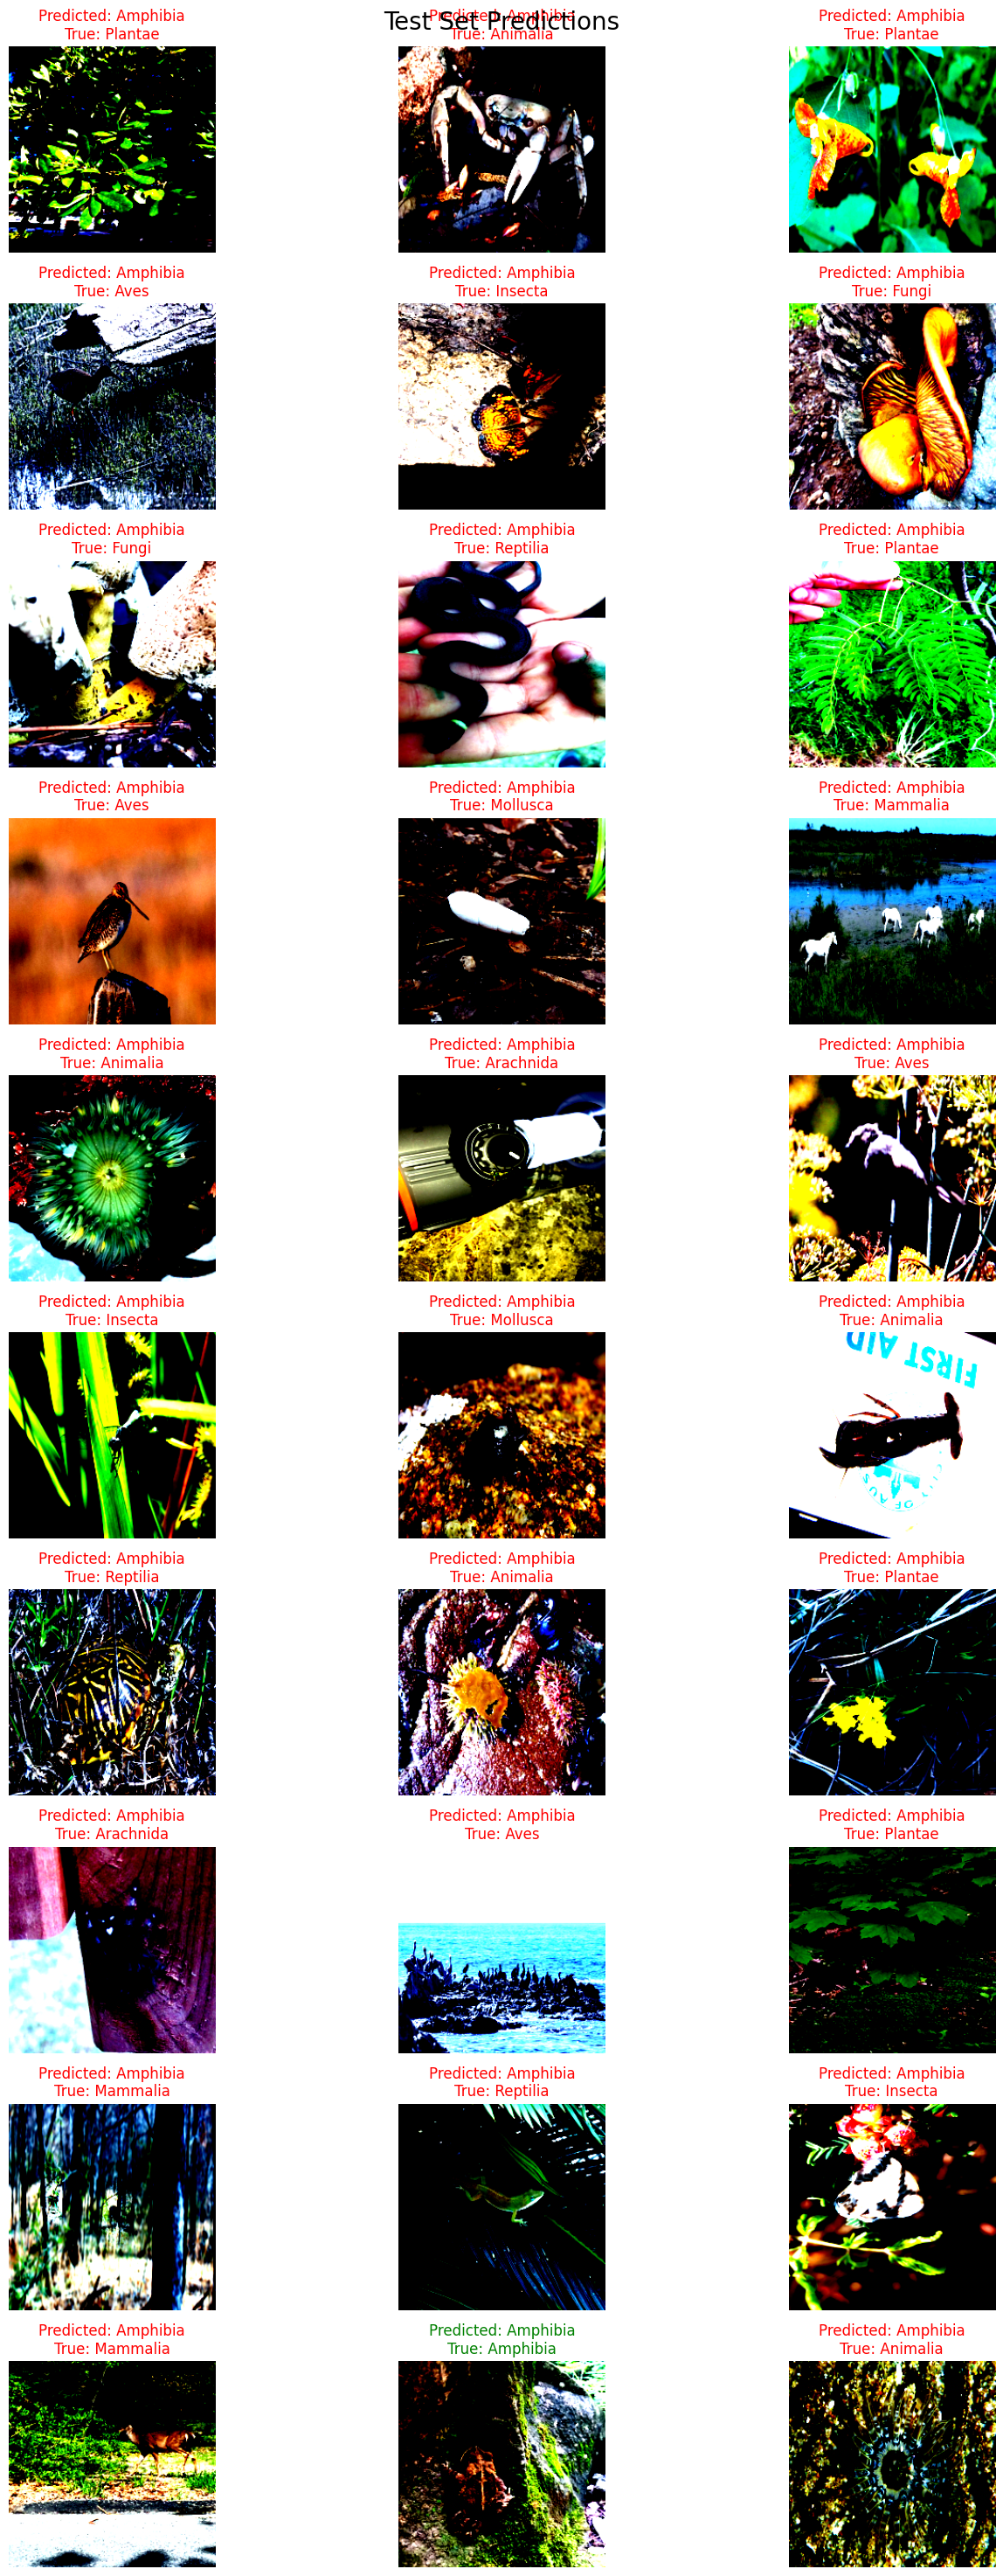

In [9]:
wandb.init(project="inaturalist_pytorch_train_and_test", job_type="final_run") #  "final_run"

visualize_predictions(model, test_loader, class_names, device)
